# California Housing Prices Prediction Problem

This notebook will show the application of several ML libraries, to a simple ML problem. It can tackle with Scikit-Learn, Pytorch or Tensorflow as it is a small dataset. However it is a good starting point to polish all the steps needed to create an analysis covering different aspects of a ML pipeline for a regression problem.

In [1]:
# Set Up libraries and environment
import os, sys, shutil, glob
import pandas as pd
import numpy as np
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "California_Housing_Prices"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Define a helper function to save plots
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Download data

The dataset can be downloaded from here:
https://www.kaggle.com/datasets/camnugent/california-housing-prices

## Load Data

In [2]:
HOUSING_PATH = os.path.join(PROJECT_ROOT_DIR, "archive")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data(HOUSING_PATH)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Exploring and cleaning a dataset

Within the ML jargon every column is named a "feature", wherear every row is a "sample". There are several commands in Pandas, which allow us to get additional information about a dataset, they are:

- df.info()
- df.describe()
- df.shape

In [3]:
housing.shape

(20640, 10)

In [4]:
housing.info()
'''
 Here we will see that the column "total bedrooms" has not the same number of samples, perhaps nans. Nans can be threated in several ways:
- 1) Remove them
- 2) fill with zeros or any other statistic, like, mean, median, min, max, or interpolate

 Also all features are numerical but ocean_proximity, which is a categorical one
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


'\n Here we will see that the column "total bedrooms" has not the same number of samples, perhaps nans. Nans can be threated in several ways:\n- 1) Remove them\n- 2) fill with zeros or any other statistic, like, mean, median, min, max, or interpolate\n\n Also all features are numerical but ocean_proximity, which is a categorical one\n'

In [5]:
# Also we can see that we have a categorical column, later on we will have to encode it in order to work with the regression model.
# Categories within a column can be seen with:

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe() # Only for numerical values

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
# Get total number of NaNs in the dataframe
housing.isnull().sum(axis = 0)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
# In this case we will replace with the median, prior to split between train, validation and test sets

median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median,inplace = True)
housing.isna().sum(axis = 0) # Check again

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [9]:
housing.describe() # Only for numerical values

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
# In Scikit-Learn there is a class to take care of missing values 
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simpleimputer#sklearn.impute.SimpleImputer

 # First we need to put apart the categorical column 'ocean_proximity'
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median') # Call an instance of SimpleImputer
housing_num = housing.drop('ocean_proximity', axis = 1) # Drop colum

# We call the fit_transform method in imputer and retrive back as a DataFrame
housing_tr = pd.DataFrame(imputer.fit_transform(housing_num), columns = housing_num.columns, index = housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


Latter on we will need to add the encoded categorical column. This can be done within the data preparation Pipeline in Scikit-Learn (or any other library)

Saving figure attribute_histogram_plots


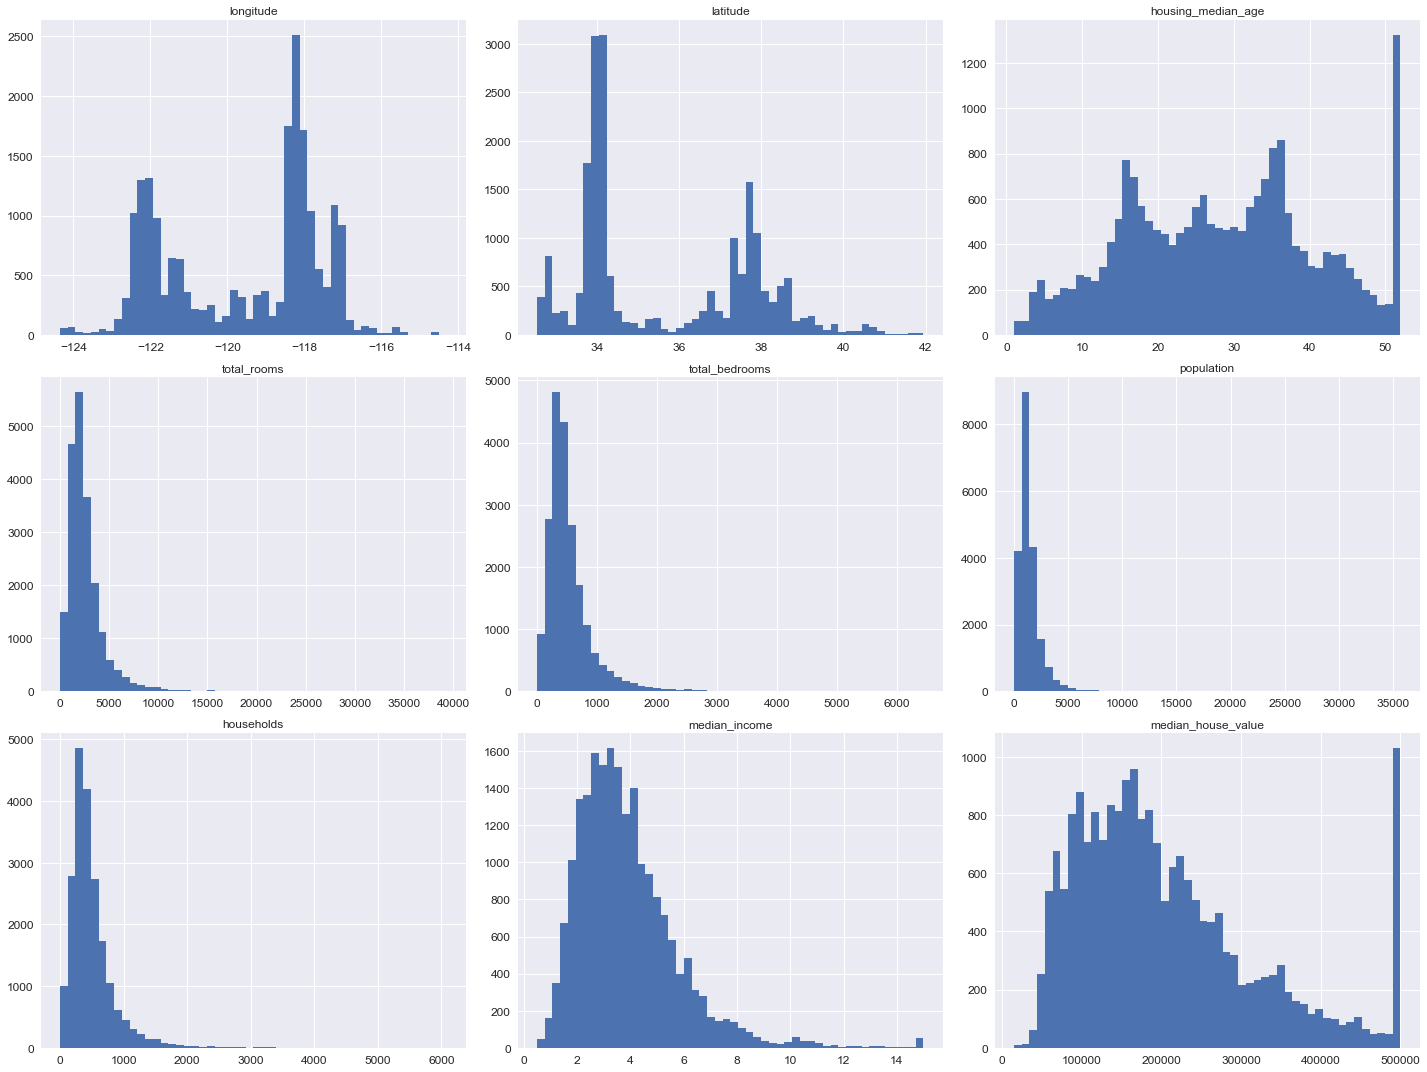

In [11]:
# Let´s plot the numerical Attributes
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

From the plots there are several things to note:

1 - The median income value has been capped at 15, that is why we see those big bars in the median house value at 50000. Also the values are given in tens of thousands of dollars.

2- The "median house value" and the "housing_median_age" were also capped. The ML will get bias from those values, so those values should be removed from the training and tests sets.

3- Features with different scales which need to be Normalized or Standarized.

4- Several plots are tail heavy. For ML they will difficul to detect patterns in these kind of distributions, so a transformation to a "bell shaped" form will work best.

### Discover and visualize the data to gain insights

Saving figure housing_prices_scatterplot


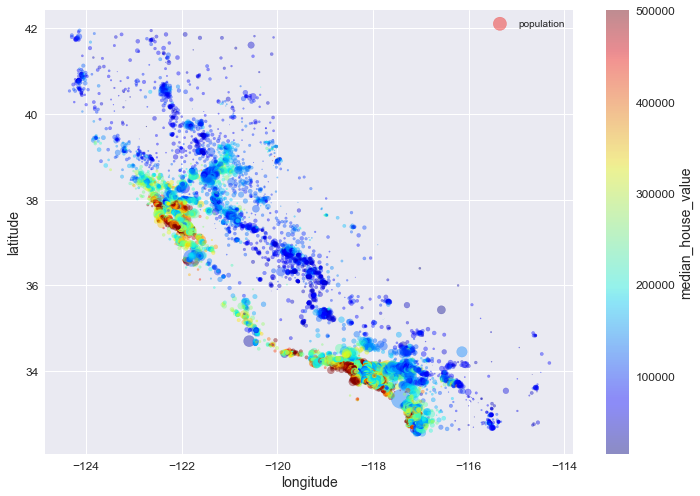

In [12]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

### Looking for Correlations

In [13]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049457
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

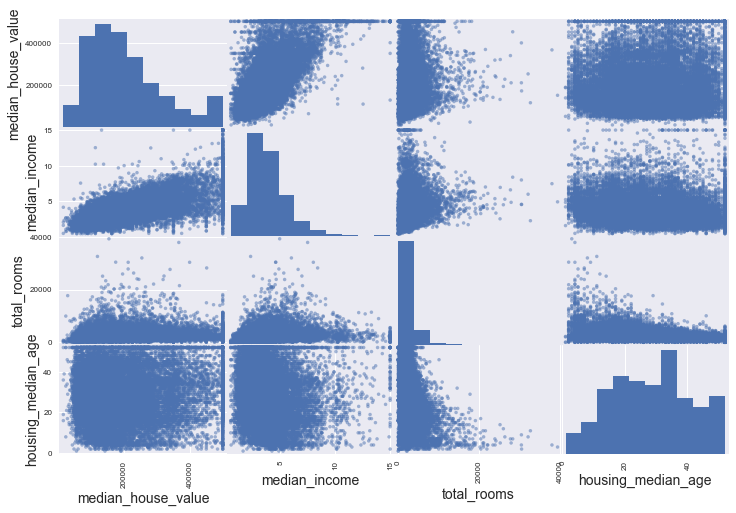

In [14]:
# Another quick way to see correlations is with the scatter_matrix plot
# Select some attributes from above list
attributes = housing[['median_house_value', 'median_income','total_rooms','housing_median_age']]

from pandas.plotting import scatter_matrix

scatter_matrix(attributes, figsize = (12,8))

In [15]:
''' Eventually the most promisin indicator to predict the median house values seems to be the median income'''

' Eventually the most promisin indicataor to predict the median house values seems to be the median income'

When we use classical methods to tackle either regression of classification problems, it is important to pay attention to the correlation between variables. Feature creation is an important part in this process, the combination of features or their statistics (mean, median, etc...), can lead to better models.

### Creation of new features manually

In [16]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [17]:
# Running Again the Correlation Matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049457
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.233303
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='rooms_per_household', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='bedrooms_per_room', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='rooms_per_household', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>,
        <AxesSubplot:xlabel='bedrooms_per_room', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='rooms_per_household'>,
        <AxesSubplot:xlabel='median_income', ylabel='rooms_per_household'>,
        <AxesSubplot:xlabel='rooms_per_household', ylabel='rooms_per_househo

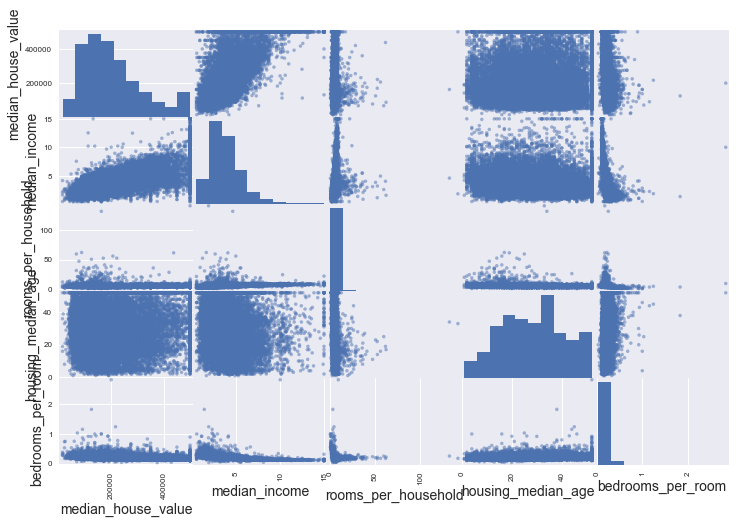

In [102]:
new_attributes = housing[['median_house_value', 'median_income','rooms_per_household','housing_median_age','bedrooms_per_room']]

from pandas.plotting import scatter_matrix

scatter_matrix(new_attributes, figsize = (12,8))

The new feature 'rooms_per_household' is much more correlated, but the other two did not seem to be an improvement for the model.

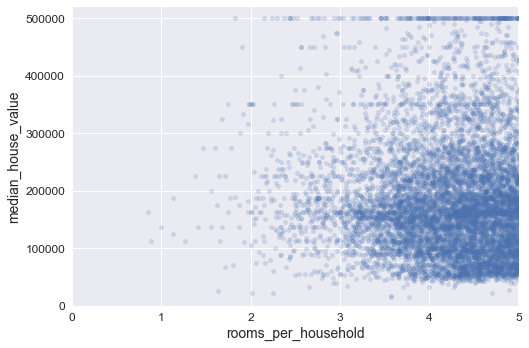

In [18]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [19]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213794,3.070655
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.065248,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.037151,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175225,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203159,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.240126,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,2.824675,1243.333333


### Creation of features by creating custom classes

In any ML project, in order to improve automation, and to work seamless in a dedicated data preparation pipeline, there exists the option to use the built-in classes in the ML libraries like, Scikit-Learn, Pytorch or Keras / Tensorflow, to create custom classes for our projects.

For instance in Scikit-Learn we can use the base classes 'BaseEstimator' and 'TransformerMixIn' to add their methods in our feature creation pipeline. so later on this class can be added to the usual Pipeline without issues.

https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html?highlight=baseestimator#sklearn.base.BaseEstimator

https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html?highlight=transformermixin#sklearn.base.TransformerMixin


In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room # New feature
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [35]:
housing_extra_attribs

array([[-122.23, 37.88, 41.0, ..., 2.5555555555555554, 6.984126984126984,
        2.5555555555555554],
       [-122.22, 37.86, 21.0, ..., 2.109841827768014, 6.238137082601054,
        2.109841827768014],
       [-122.24, 37.85, 52.0, ..., 2.8022598870056497, 8.288135593220339,
        2.8022598870056497],
       ...,
       [-121.22, 39.43, 17.0, ..., 2.325635103926097, 5.20554272517321,
        2.325635103926097],
       [-121.32, 39.43, 18.0, ..., 2.1232091690544412, 5.329512893982808,
        2.1232091690544412],
       [-121.24, 39.37, 16.0, ..., 2.616981132075472, 5.254716981132075,
        2.616981132075472]], dtype=object)

## Train - Test Split with Stratified Shuffle

In order to avoid bias in datasets, it is recommended, specially in small datasets, to perform a stratified sampling, and also to perform a k-Fold Cross Validation. 

The first technique will perform a shuffle in the train and test sets, assuring that there are enough samples of each class, or numerical bins, so bias is reduced or avoid in train and predict phases. Usually the shuffle is based on the importance or correlation of attributes to the figure that wants to be predicted.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [22]:
# Now we should remove 'income_cat' attibute 
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Prepare the Data for ML Algorithms. The compact Pipeline.

In [23]:
# First of all it is necessary to put apart the column we want to predict, in this case the 'median_house_value'

housing_train = strat_train_set.drop('median_house_value',axis = 1)
housing_label_train = strat_train_set['median_house_value'].copy()

housing_test = strat_test_set.drop('median_house_value',axis = 1)
housing_label_test = strat_test_set['median_house_value'].copy()

# Still there is one thing we have not done, it is to encode the categorical column 'ocean_proximity' in housing
# Also before feeding the data into the model it need to be normalized through Min-Max Scaler or standarized through a Standard Scaler

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Pipeline preparation for numerical features:

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy = 'median')),
    ('added_features', CombinedAttributesAdder()),
    ('std_scaler',StandardScaler())
])


# To handle numerical and categorical columns in the same pipeline

housing_num = housing_train.drop('ocean_proximity',axis = 1)
housing_num_train = num_pipeline.fit_transform(housing_num)


In [25]:
housing_num_train

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12116857],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81002963],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33804097],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32225345],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45663897],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12174279]])

In [26]:
from sklearn.compose import ColumnTransformer
housing_num_attribs = list(housing_num)
housing_cat_attribs = ['ocean_proximity']

# Note it is needed to pass the names of the features in a list (not as dataframe)
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, housing_num_attribs),
    ('cat',OneHotEncoder(), housing_cat_attribs)
])

housing_prepared_train = full_pipeline.fit_transform(housing_train)

In [27]:
housing_num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

In [28]:
housing_cat_attribs

['ocean_proximity']

## Select and Train a Model

In Scikit-Learn there is awhole set of models to perform Regression task, from simple LinearRegression to more complex ensembles or XGBoost.

Take a look to the Scikit-Learn API

<b> Classical linear regressors
- linear_model.LinearRegression(*[, ...]) --> Ordinary least squares Linear Regression.

- linear_model.Ridge([alpha, fit_intercept, ...]) --> Linear least squares with l2 regularization.

- linear_model.RidgeCV([alphas, ...]) --> Ridge regression with built-in cross-validation.

- linear_model.SGDRegressor([loss, penalty, ...]) --> Linear model fitted by minimizing a regularized empirical loss with SGD.
 
<b> Regressors with variable selection
    
- linear_model.ElasticNet([alpha, l1_ratio, ...])
- linear_model.ElasticNetCV(*[, l1_ratio, ...])
- linear_model.Lars(*[, fit_intercept, ...])
- linear_model.LarsCV(*[, fit_intercept, ...])
- linear_model.Lasso([alpha, fit_intercept, ...])
- linear_model.LassoCV(*[, eps, n_alphas, ...])
- linear_model.LassoLars([alpha, ...])
- linear_model.LassoLarsCV(*[, fit_intercept, ...])
- linear_model.LassoLarsIC([criterion, ...])
- linear_model.OrthogonalMatchingPursuit(*[, ...])
- linear_model.OrthogonalMatchingPursuitCV(*)

    
- neighbors.KNeighborsRegressor([n_neighbors, ...])
- linear_model.ARDRegression(*[, n_iter, tol, ...])
- linear_model.BayesianRidge(*[, n_iter, tol, ...])
- neural_network.MLPRegressor([...])
- svm.LinearSVR(*[, epsilon, tol, C, loss, ...])
- tree.DecisionTreeRegressor(*[, criterion, ...])
    
https://xgboost.readthedocs.io/en/stable/index.html
    
etc...
    
The idea is to run 4 to 5 models, compare their RMSE, and then perform a GridSearchValue of those with more promising performance

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared_train, housing_label_train)

LinearRegression()

In [54]:
# Let´s compute some metric to measure the error. For Regression task the MAE or RMSE are good candidates

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,  r2_score

housing_predictions = lin_reg.predict((housing_prepared_train))
lin_mse = mean_squared_error(housing_label_train, housing_predictions)
lin_rmse = np.sqrt(lin_mse) # The smaller the RMSE the better is the prediction

lin_mae_per = mean_absolute_percentage_error(housing_label_train, housing_predictions)

lin_r2_score= r2_score(housing_label_train, housing_predictions)
print(lin_rmse,lin_mae_per, lin_r2_score)

68630.0600914923 0.28464986378632967 0.6481329465499935


We are off by a 53%, this is an example of underfitting, the model is not powerfull enough, or the features do not contain enough information.
Let´s train another two regressors, a Decission Tree and a SVR(). Think that when we run describe() command above, the mean of the median house value was around 206588

In [55]:
from sklearn.tree import DecisionTreeRegressor


tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared_train, housing_label_train)


housing_predictions_tree = tree_reg.predict((housing_prepared_train))
tree_mse = mean_squared_error(housing_label_train, housing_predictions_tree)
tree_rmse = np.sqrt(tree_mse)

tree_mae_per = mean_absolute_percentage_error(housing_label_train, housing_predictions_tree)
tree_r2_score= r2_score(housing_label_train, housing_predictions_tree)
print(tree_rmse, tree_mae_per, tree_r2_score)

0.0 0.0 1.0


In [89]:
from sklearn.svm import SVR
svr_reg = SVR(kernel = 'linear',C = 100,epsilon = 0.01)
svr_reg.fit(housing_prepared_train, housing_label_train)


housing_predictions_svr = svr_reg.predict((housing_prepared_train))
svr_mse = mean_squared_error(housing_label_train, housing_predictions_svr)
svr_rmse = np.sqrt(svr_mse)

svr_mae_per = mean_absolute_percentage_error(housing_label_train, housing_predictions_svr)

svr_r2_score = r2_score(housing_label_train, housing_predictions_svr)
# For the mean_absolute_error the best value is 0.0
print(svr_rmse, svr_mae_per, -svr_r2_score)


71285.10841436344 0.2532714578759965 -0.620381407355481


 The SVR with some regularization in epsilon an C gives the best score. 

With small datasets a common approach is to split the train set in several folds, keepin one the folds as a validation dataset, and then retrieving the scores of each fold.
 
 In Scikit-Learn this can be done with K-Fold cross-validation feature

### A note on XGBoost

The library XGBoost is an ensemble method, more info at:
https://xgboost.readthedocs.io/en/stable/index.html

Which can be easily adapted thanks to its API to work with Scikit-Learn

More examples here:
https://machinelearningmastery.com/xgboost-for-regression/

XGBoost in one of the algorithms with best results in Kaggle Competitions.

In [93]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(
    tree_method="hist",
    eval_metric= mean_squared_error,
    max_depth = 6,
    n_estimators = 1000, # The more estimators the beeter
    eta = 1 # The closer to 1 the better
)
xgb_reg.fit(housing_prepared_train, housing_label_train)

housing_predictions_xgb = xgb_reg.predict((housing_prepared_train))
xgb_mse = mean_squared_error(housing_label_train, housing_predictions_xgb)
xgb_rmse = np.sqrt(xgb_mse)

xgb_mae_per = mean_absolute_percentage_error(housing_label_train, housing_predictions_xgb)
xgb_r2_score = r2_score(housing_label_train, housing_predictions_xgb)
print(xgb_rmse , xgb_mae_per, xgb_r2_score)

44.31686452268642 0.00021022237486936616 0.9999998532804799


## Fine Scores using K-Fold Cross Validation

In [48]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared_train, housing_label_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [49]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72895.21316148 68900.8097384  67669.15224564 71856.3287497
 67193.74583712 77964.36318297 68866.41724577 74137.76506043
 70448.12593082 72237.03238147]
Mean: 71216.89535337969
Standard deviation: 3139.718566534221


After cross-validation the Decission Tree does not perform as good, it even performs worst than the simple regression model. In this case we need to go for one model more powerfull like those presented before.

In [50]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared_train, housing_label_train)

housing_predictions_forest = forest_reg.predict(housing_prepared_train)
forest_mse = mean_squared_error(housing_label_train, housing_predictions_forest)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18675.993488906755

In [51]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared_train, housing_label_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51365.22522393 48702.38709582 47189.45691214 51873.04681518
 47538.42727533 51854.56567498 52673.44967788 50031.88239123
 48777.50513063 54055.75738784]
Mean: 50406.17035849635
Standard deviation: 2188.5181713646816


In [82]:
# Note to save models

import joblib
joblib.dump(xgb_reg,'California_Housing_XGBoost.parquet')

# model_loaded = joblib.load('California_Housing_XGBoost.parquet')

['California_Housing_XGBoost.parquet']

## Hyperparameters Tunning

### Grid Search CV

In [85]:
### Grid Search CV
from sklearn.model_selection import GridSearchCV

# A list with 2 dictionaries inside
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared_train, housing_label_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [86]:
# The best hyperparameter combination found:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [87]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [88]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

66154.92948079269 {'max_features': 2, 'n_estimators': 3}
57029.77271556489 {'max_features': 2, 'n_estimators': 10}
54247.47091383158 {'max_features': 2, 'n_estimators': 30}
61899.396461589946 {'max_features': 4, 'n_estimators': 3}
54248.42082057379 {'max_features': 4, 'n_estimators': 10}
51896.670721845294 {'max_features': 4, 'n_estimators': 30}
61209.691619325815 {'max_features': 6, 'n_estimators': 3}
53462.243205612074 {'max_features': 6, 'n_estimators': 10}
51308.9879421162 {'max_features': 6, 'n_estimators': 30}
59887.55514241807 {'max_features': 8, 'n_estimators': 3}
52862.34908517232 {'max_features': 8, 'n_estimators': 10}
51042.7904778823 {'max_features': 8, 'n_estimators': 30}
64702.20205569516 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56191.98616315218 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61316.05251282602 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53593.435856275704 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [94]:
# We can send the results to a dataframe
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.183799,0.008915,0.004945,0.006419,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.461562e+09,-4.143637e+09,...,-4.376475e+09,1.407469e+08,18,-1.170444e+09,-1.209129e+09,-1.163751e+09,-1.148242e+09,-1.175378e+09,-1.173389e+09,2.007596e+07
1,0.636001,0.078113,0.026753,0.010216,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.413861e+09,-3.099697e+09,...,-3.252395e+09,1.247514e+08,11,-6.127252e+08,-6.357002e+08,-6.113380e+08,-6.281179e+08,-6.223091e+08,-6.220381e+08,9.218595e+06
2,1.689133,0.020505,0.071786,0.007609,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-3.016147e+09,-2.822550e+09,...,-2.942788e+09,9.892170e+07,8,-4.535103e+08,-4.638941e+08,-4.594159e+08,-4.701503e+08,-4.556870e+08,-4.605315e+08,5.963889e+06
3,0.274198,0.008008,0.008664,0.007529,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-4.004589e+09,-3.615236e+09,...,-3.831535e+09,1.510318e+08,16,-1.058789e+09,-1.042258e+09,-1.031523e+09,-9.912456e+08,-1.009963e+09,-1.026756e+09,2.379966e+07
4,0.920783,0.017840,0.025609,0.008229,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.946722e+09,-2.822901e+09,...,-2.942891e+09,7.960708e+07,9,-5.528630e+08,-5.471166e+08,-5.443491e+08,-5.519941e+08,-5.524566e+08,-5.497559e+08,3.410480e+06
5,2.710866,0.060546,0.062585,0.005951,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.753200e+09,-2.596027e+09,...,-2.693264e+09,9.368206e+07,3,-4.124038e+08,-4.153412e+08,-4.145840e+08,-4.140243e+08,-4.106124e+08,-4.133931e+08,1.692504e+06
6,0.381944,0.009014,0.006818,0.008350,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.719359e+09,-3.532933e+09,...,-3.746626e+09,1.458813e+08,14,-9.988192e+08,-1.019239e+09,-1.007757e+09,-1.011179e+09,-1.008429e+09,-1.009085e+09,6.558487e+06
7,1.253282,0.012265,0.022439,0.006948,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.837050e+09,-2.773329e+09,...,-2.858211e+09,7.048820e+07,6,-5.359701e+08,-5.439937e+08,-5.332365e+08,-5.411783e+08,-5.442890e+08,-5.397335e+08,4.412782e+06
8,3.723099,0.037069,0.067306,0.010482,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.618651e+09,-2.529828e+09,...,-2.632612e+09,8.980938e+07,2,-4.068527e+08,-4.083350e+08,-4.084217e+08,-3.970490e+08,-4.040517e+08,-4.049420e+08,4.251193e+06
9,0.469331,0.007866,0.012686,0.007939,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.686969e+09,-3.626635e+09,...,-3.586519e+09,2.158050e+08,12,-9.636042e+08,-9.880414e+08,-9.242751e+08,-1.003911e+09,-9.658761e+08,-9.691416e+08,2.690898e+07


### Randomized Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

Randomized Search for SVR linear model

In [96]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svr_reg, param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(housing_prepared_train, housing_label_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  23.6s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  28.8s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  24.6s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  23.4s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  21.7s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  20.8s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  21.0s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  21.0s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  20.9s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  21.3s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  21.8s
[CV] END ....C=1.5808361216819946, gamma=0.05399

RandomizedSearchCV(cv=3, estimator=SVR(C=100, epsilon=0.01, kernel='linear'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002630F26E220>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002630D71B400>},
                   random_state=42, verbose=2)

In [97]:
rnd_search_cv.best_estimator_

SVR(C=9.324426408004218, epsilon=0.01, gamma=0.0026587543983272693,
    kernel='linear')

In [98]:
y_pred = rnd_search_cv.best_estimator_.predict(housing_prepared_train)
mse = mean_squared_error(housing_label_train, y_pred)
np.sqrt(mse)

82678.51430504926

In [99]:
housing_prepared_test = full_pipeline.fit_transform(housing_test)

In [100]:
y_pred = rnd_search_cv.best_estimator_.predict(housing_prepared_test)
mse = mean_squared_error(housing_label_test, y_pred)
np.sqrt(mse)

80933.07531565872

## Regression Problems with Neural Networks. Keras / Tensorflow

In [104]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__, keras.__version__)
#from d2l import tensorflow as d2l

2.9.0 2.9.0


For this regression problem we can use the Sequential API from Keras by adding some layers and its activation functions.
The steps are common:

- 1- Define a model,
- 2- Compile the model, defining the optimizer, the function loss and the metrics. Last two can be predefined by user creating custom loss and metrics functions
- 3- Fit the model,i.e train model
- 4- Check training and validation loss for overfitting
- 5- Launch a prediction over test set with predict
- 6- Fine Tune Model, and save best parameter

In [108]:
from keras import models
from keras import layers

# We can create a model within a function or simply add in lines de sequential creation
def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # A REgression Model with one output House Median Income
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [109]:
# housing_prepared_train, housing_label_train, housing_prepared_test, housing_label_test

X_train, X_valid, y_train, y_valid = train_test_split(housing_prepared_train, housing_label_train, random_state=42)

In [110]:
model = build_model()
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
387/387 [==============================] - 14s 6ms/step - loss: 56214237184.0000 - mae: 206833.2188 - val_loss: 55832412160.0000 - val_mae: 206477.8750
Epoch 2/20
387/387 [==============================] - 2s 4ms/step - loss: 55531814912.0000 - mae: 205348.8438 - val_loss: 54570065920.0000 - val_mae: 203709.0000
Epoch 3/20
387/387 [==============================] - 2s 4ms/step - loss: 53472526336.0000 - mae: 200838.8438 - val_loss: 51573399552.0000 - val_mae: 197015.7031
Epoch 4/20
387/387 [==============================] - 2s 4ms/step - loss: 49392844800.0000 - mae: 191627.5156 - val_loss: 46344126464.0000 - val_mae: 184923.4219
Epoch 5/20
387/387 [==============================] - 2s 4ms/step - loss: 43068235776.0000 - mae: 176356.0938 - val_loss: 38883000320.0000 - val_mae: 166130.0000
Epoch 6/20
387/387 [==============================] - 2s 4ms/step - loss: 34619310080.0000 - mae: 153961.4844 - val_loss: 29932167168.0000 - val_mae: 140301.1094
Epoch 7/20
387/387 [=======

In [111]:
mse_test = model.evaluate(housing_prepared_test, housing_label_test)
X_new = housing_prepared_test[:3]
y_pred = model.predict(X_new)

1/1 [==============================] - 7s 7s/step


In [114]:
print(y_pred)

[[507248.06]
 [272814.72]
 [255166.81]]


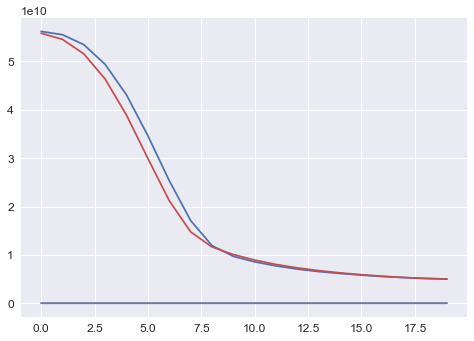

In [113]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Let´s try with a prepared version of this dataset from Scikit-Learn

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

model = build_model()
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### A function to perform K-Fold Cross Validation when the dataset is small

In [126]:
def kFold_keras_model(folds, epochs, train_data,train_targets):
    k = folds
    num_val_samples = len(train_data) // k
    num_epochs = epochs
    all_scores = []
    for i in range(k):
        print('processing fold #', i)
        # Prepare the validation data: data from partition # k
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        # Prepare the training data: data from all other partitions
        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0)

        # Build the Keras model (already compiled)
        model = build_model()
        # Train the model (in silent mode, verbose=0)
        model.fit(partial_train_data, partial_train_targets,
                  epochs=num_epochs, batch_size=1, verbose=0)
        # Evaluate the model on the validation data
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_mae)
        
        return val_mse, val_mae, all_scores

In [127]:
folds = 3
epoch = 100
val_mse, val_mae, allScores =  kFold_keras_model(folds, epoch, housing_prepared_train,housing_label_train)

processing fold # 0


In [125]:
allScores

[42334.16796875]

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## Regression problems with Neural Networks. PyTorch

In [ ]:
import torch
from torch import nn
#from d2l import torch as d2l

## Regression problems with Neural Networks. Keras / Tensorflow